In [53]:
%pip install -U textblob
!python -m textblob.download_corpora

%pip install nltk

%pip install --upgrade gensim

Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package brown to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finis

In [54]:
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

import gensim
from gensim.models import Word2Vec

from datetime import datetime

from IPython.display import Markdown, display
string = '# Start'
display(Markdown(string+' Coding'))

# Start Coding

In [55]:
def str_to_timestamp(s):
    out=[]

    s2=str.split(s,'+')
    s3=str.split(s2[0],' ')

    s4=str.split(s3[0],'-')

    s5=str.split(s3[1],':')
    year=int(s4[0])
    month=int(s4[1])
    day=int(s4[2])
    hour=int(s5[0])
    minute=int(s5[1])
    second=int(s5[2])

    return(datetime(year=year,month=month,day=day,hour=hour,minute=minute,second=second).timestamp())

from nltk.tokenize import word_tokenize

def NumStr(mot):
    res = ''.join(filter(lambda i: i.isdigit(), mot))
    if (res==''):
        return False
    return True


def extract_keywords(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Apply part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Select only nouns and adjectives
    keywords = [word for word, pos in tagged_tokens if (pos in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'] and not NumStr(word))]

    return keywords

def extract_sentiment_polarity(text):
    blob=TextBlob(text)
    return(blob.sentiment.polarity)

In [56]:
data=pd.read_csv('data/minnesota.csv')
df=data
print('start')

df['keywords'] = df['tweet_text'].apply(extract_keywords)

print('end of keywords')

df['sentiment_polarity']=df['tweet_text'].apply(extract_sentiment_polarity)

print('end of polarity')

df['timestamps']=df['tweet_created_dt'].apply(str_to_timestamp)
df['timestamps']=df['timestamps']-df['timestamps'].min()

print('end of timestamps')

clean_data=df

start
end of keywords
end of polarity
end of timestamps


In [57]:
def sliding_window(df,size,sliding):
    X_out=[]

    for time in range(0,int(df['timestamps'].max()),sliding):
        o=df[df.timestamps<time+size]
        X_out.append(o[o.timestamps>time])

        print("%.3f" % (time/int(df['timestamps'].max())), end="\r")
    print("finish")
    return X_out[:-1]

def dfToListofVectors(df):
    out=[]
    for l_vect in df.vectors:
        for v in l_vect:
            
            out.append(v)
            
    return out

In [308]:
time_day=60*60*24
L=sliding_window(clean_data,time_day*3,time_day)
first=L[0]

vector_size=100
model = Word2Vec(sentences=first['keywords'], vector_size=vector_size, window=0, min_count=0, workers=0)
model.save("Word2vec_models/test_word2vec.model")
word_vectors = model.wv

i=0
for keywords in first.keywords:
    for keyword in keywords:
        i+=1

arr=np.ndarray((i,vector_size))
i=0
for keywords in first.keywords:

    for keyword in keywords:
        
        arr[i]=word_vectors[keyword]
        i+=1

finish


In [309]:
l_sent=[]
for i in range(len(L)):
    l_sent.append(L[i].sentiment_polarity.mean())

n_tweets=[]
for i in range(len(L)):
    n_tweets.append(L[i].shape[0])


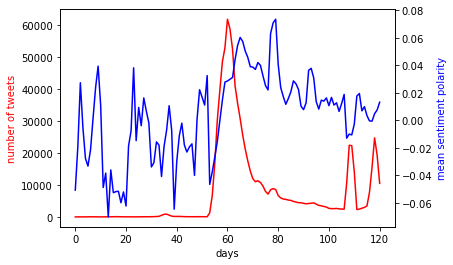

In [310]:
fig, axe1_X = plt.subplots()
axe2_X = axe1_X.twinx()
color1='red'
color2='blue'
axe1_X.plot(range(len(L)), n_tweets, color1)
axe2_X.plot(range(len(L)), l_sent, color2)
axe1_X.set_xlabel('days')
axe1_X.set_ylabel('number of tweets', color=color1)
axe2_X.set_ylabel('mean sentiment polarity', color=color2)
plt.savefig("figures_out/n_tweets_and_sent_pol.png",transparent=True)

In [311]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

time_day=60*60*24
nb_bins=int(clean_data['timestamps'].max()/time_day)
coef_smooth=int(nb_bins/10)

hist,e=np.histogram(clean_data['timestamps'],nb_bins)
smooth_hist=smooth(hist,coef_smooth)
x_hist=range(nb_bins)
dhist=np.gradient(smooth_hist,x_hist)
#plt.plot(x_hist,dhist)
the_time=e[dhist.argmax()]

We want to identify the weak signal before this time ( which is the time where the number of tweets increase the most) and as soon as possible

In [329]:
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance
NUM_CLUSTERS = 10

time_day=60*60*24


clean_data2=clean_data[clean_data['timestamps']<the_time]


L_cos=sliding_window(clean_data2,time_day*3,time_day//2)
first=L_cos[0]
print(len(L_cos))
#L_cos=L_cos[0:2*len(L_cos)//6]

finish
112


In [330]:
vector_size=100
model = Word2Vec(sentences=first['keywords'], vector_size=vector_size, window=0, min_count=0, workers=0)
model.save("Word2vec_models/test_word2vec.model")
word_vectors = model.wv

i=0
for keywords in first.keywords:
    for keyword in keywords:
        i+=1

arr=np.ndarray((i,vector_size))
i=0
for keywords in first.keywords:

    for keyword in keywords:
        
        arr[i]=word_vectors[keyword]
        i+=1

X=arr
print(X.shape)

(163, 100)


In [331]:
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=cosine_distance, repeats=10,avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X,assign_clusters=True)

L_centroids=kclusterer.means()

l_image_of_centroids=[]
    
n_top_word=5
for i in range(len(L_centroids)):
        #print(word_vectors.similar_by_vector(centroids[i],topn=1))
    closest_word_of_centroid=word_vectors.similar_by_vector(L_centroids[i],topn=n_top_word)
    l_image_of_centroids.append(closest_word_of_centroid)

In [332]:
itt=0
itt_max=len(L_cos)
list_of_centroids_cos=[L_centroids]
list_of_centroids_with_words_cos=[l_image_of_centroids]
for seq in L_cos[1:]:
    print("%.3f" % (itt/itt_max), end="\r")
    itt+=1
    if False:
        model = Word2Vec(sentences=seq['keywords'], vector_size=100, window=0, min_count=0, workers=0)
        model.save("Word2vec_models/test_word2vec.model")
        word_vectors = model.wv
        del model
    model.build_vocab(seq['keywords'], update=True)
    model.train(seq['keywords'], total_examples=model.corpus_count, epochs=model.epochs)
    word_vectors = model.wv
    

    i=0
    for keywords in seq.keywords:
        for keyword in keywords:
            i+=1

    arr=np.ndarray((i,100))
    i=0
    for keywords in seq.keywords:

        for keyword in keywords:
            
            arr[i]=word_vectors[keyword]
            i+=1
    X=arr
    #kmeans=k_means(X,n_clusters=5,n_init='auto')
    #centroids=kmeans[0]
    if False:
        kmeans=KMeans(n_clusters=n_clusters,init=centroids,n_init=1)
        kmeans.fit(X)
        centroids=kmeans.cluster_centers_
    kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=cosine_distance,avoid_empty_clusters=True,initial_means=L_centroids,repeats=1)
    assigned_clusters = kclusterer.cluster(X,assign_clusters=True)
    L_centroids=kclusterer.means()
    


    list_of_centroids_cos.append(L_centroids)
    l_image_of_centroids=[]
    
    n_top_word=5
    for i in range(len(L_centroids)):
        #print(word_vectors.similar_by_vector(centroids[i],topn=1))
        closest_word_of_centroid=word_vectors.similar_by_vector(L_centroids[i],topn=n_top_word)
        l_image_of_centroids.append(closest_word_of_centroid)
    list_of_centroids_with_words_cos.append(l_image_of_centroids)
    #display(Markdown('### New centroids'))
    #for i in range(centroids.shape[0]):
        #print(word_vectors.similar_by_vector(centroids[i],topn=1))
print('finish')

finish


In [333]:
L_dist=[]
L_dist_max=[]
for j in range(len(list_of_centroids_cos[i])):
    L_dist_per_cluster=[0]
    for i in range(1,len(list_of_centroids_cos)):
        L_dist_per_cluster.append(cosine_distance(list_of_centroids_cos[i][j],list_of_centroids_cos[i-1][j]))
    L_dist.append(L_dist_per_cluster)
    L_dist_max.append(np.asarray(L_dist_per_cluster).max())
    print("max distance for cluster "+str(j)+" = %f"%np.asarray(L_dist_per_cluster).max())

max distance for cluster 0 = 0.293415
max distance for cluster 1 = 0.328015
max distance for cluster 2 = 0.399435
max distance for cluster 3 = 0.126180
max distance for cluster 4 = 0.503025
max distance for cluster 5 = 0.086158
max distance for cluster 6 = 0.431412
max distance for cluster 7 = 0.572225
max distance for cluster 8 = 0.067804
max distance for cluster 9 = 0.255565


In [334]:
cluster_max_distance=np.where(L_dist_max == np.max(L_dist_max))[0][0]
cluster_max_distance

7

In [335]:
L_ind=[]
for i in range(len(L_dist)):
    print('indice de déplacement de la moyenne des points du cluster n°'+str(i)+" : %d"%np.where(np.asarray(L_dist[i])==np.asarray(L_dist[i]).max())[0][0])
    L_ind.append(np.where(np.asarray(L_dist[i])==np.asarray(L_dist[i]).max())[0][0])
    #print(np.where(np.asarray(L_dist[i_max])==np.asarray(L_dist[i_max]).max()))
ind_max=int(np.max(L_ind))
ind_max

indice de déplacement de la moyenne des points du cluster n°0 : 106
indice de déplacement de la moyenne des points du cluster n°1 : 104
indice de déplacement de la moyenne des points du cluster n°2 : 106
indice de déplacement de la moyenne des points du cluster n°3 : 106
indice de déplacement de la moyenne des points du cluster n°4 : 106
indice de déplacement de la moyenne des points du cluster n°5 : 106
indice de déplacement de la moyenne des points du cluster n°6 : 106
indice de déplacement de la moyenne des points du cluster n°7 : 106
indice de déplacement de la moyenne des points du cluster n°8 : 106
indice de déplacement de la moyenne des points du cluster n°9 : 106


106

In [336]:
arr_dist=np.ndarray(shape=(len(L_dist),len(L_dist[0])))
for i in range(arr_dist.shape[0]):
    for j in range(arr_dist.shape[1]):
        arr_dist[i,j]=L_dist[i][j]

In [337]:
l_sent_cos=[]
for i in range(len(L_cos)):
    l_sent_cos.append(L_cos[i].sentiment_polarity.mean())

n_tweets_cos=[]
for i in range(len(L_cos)):
    n_tweets_cos.append(L_cos[i].shape[0])


Text(0, 0.5, 'mean sentiment polarity')

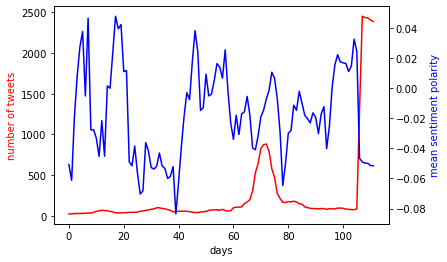

In [338]:

fig, axe1_X = plt.subplots()
axe2_X = axe1_X.twinx()
color1='red'
color2='blue'
axe1_X.plot(range(len(L_cos)), n_tweets_cos, color1)
axe2_X.plot(range(len(L_cos)), l_sent_cos, color2)
axe1_X.set_xlabel('days')
axe1_X.set_ylabel('number of tweets', color=color1)
axe2_X.set_ylabel('mean sentiment polarity', color=color2)


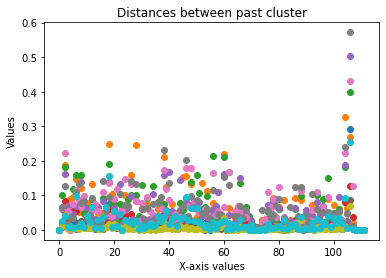

In [339]:
import numpy as np
import matplotlib.pyplot as plt

ind_test=112
arr = arr_dist[:,0:ind_test]

# plot the values of the 10 points against the x-axis values
x = np.arange(ind_test)
for i in range(NUM_CLUSTERS):
    plt.scatter(x, arr[i])
    

# set the title and labels for the plot
plt.title('Distances between past cluster')
plt.xlabel('X-axis values')
plt.ylabel('Values')

# display the plot
plt.show()


### For each iteration we look at the cluster that move the most

In [340]:
counting=np.zeros(NUM_CLUSTERS)
for i in range(arr.shape[1]):
    counting[np.where(arr[:,i]==arr[:,i].max())]+=1
counting-=counting.min()
counting

array([ 0., 22., 20.,  1., 19.,  0., 30., 18.,  0.,  1.])

In [373]:
list_of_centroids_with_words_cos[ind_max][cluster_max_distance]

[('george', 0.8995270729064941),
 ('video', 0.46493321657180786),
 ('penalties', 0.3765183985233307),
 ('criminalintensions', 0.34576156735420227),
 ('live', 0.34187978506088257)]

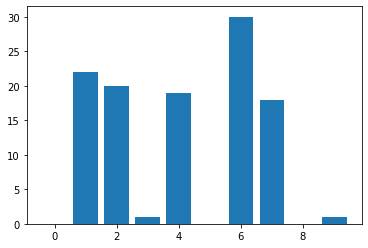

In [374]:
plt.bar(range(NUM_CLUSTERS),counting)
plt.show()

In [375]:
def top_n_ind(arr_in,n):
    arr=arr_in.copy()
    #out=np.zeros(n,dtype=int)
    out=[]
    i=0
    while (i<n and arr[arr.argmax()]!=-1):
        out.append(arr.argmax())
        arr[arr.argmax()]=-1
        i+=1
    return(np.asarray(out))

In [376]:
arr_centroids_words=np.ndarray((len(L_cos),NUM_CLUSTERS),dtype=object)
for i in range(arr_centroids_words.shape[0]):
    for j in range(arr_centroids_words.shape[1]):
        arr_centroids_words[i,j]=list_of_centroids_with_words_cos[i][j]

In [381]:
arr_centroids_words[ind_max,top_n_ind(counting,3)]

array([list([('justiceforgeorgefloyd', 0.44543907046318054), ('officer', 0.38190606236457825), ('unspeakable', 0.3689442276954651), ('bang', 0.3665825128555298), ('nobody', 0.3612801134586334)]),
       list([('racism', 0.5108630657196045), ('life', 0.4935244023799896), ('folks', 0.4226604998111725), ('rip', 0.40359506011009216), ('words', 0.39494726061820984)]),
       list([('icantbreathe', 0.8599129319190979), ('time', 0.44545090198516846), ('enemy', 0.42822161316871643), ('piers', 0.3633686602115631), ('please', 0.35530149936676025)])],
      dtype=object)

### Two things :
- We can follow the clusters that move the most before the strong signal appear. Those clusters tend to be the heart of the strong signal
- However the most signifant cluster will be the one that move the most when important new keywords appear and we can't say that it we'll be part of the most moving clusters

## Results :

Cluster that moves the most in general :

In [385]:
arr_centroids_words[ind_max,top_n_ind(counting,3)]

array([list([('justiceforgeorgefloyd', 0.44543907046318054), ('officer', 0.38190606236457825), ('unspeakable', 0.3689442276954651), ('bang', 0.3665825128555298), ('nobody', 0.3612801134586334)]),
       list([('racism', 0.5108630657196045), ('life', 0.4935244023799896), ('folks', 0.4226604998111725), ('rip', 0.40359506011009216), ('words', 0.39494726061820984)]),
       list([('icantbreathe', 0.8599129319190979), ('time', 0.44545090198516846), ('enemy', 0.42822161316871643), ('piers', 0.3633686602115631), ('please', 0.35530149936676025)])],
      dtype=object)

Cluster that move the most in one iteration

In [384]:
arr_centroids_words[ind_max,cluster_max_distance]

[('george', 0.8995270729064941),
 ('video', 0.46493321657180786),
 ('penalties', 0.3765183985233307),
 ('criminalintensions', 0.34576156735420227),
 ('live', 0.34187978506088257)]